## Álvaro Sánchez de la Cruz, Marc Gil Arnau
# Tarea 2
# Máquina de Vectores Soporte

# Índice de Contenidos

1. [Configuración Inicial y Preprocesamiento](#configuracion)
2. [Sección I. Esquema Lineal](#seccion-i)
    * 2.1. SVM Lineal Base: Análisis de coeficientes sin normalizar
    * 2.2. Normalización y SVM Lineal Normalizado
    * 2.3. Comparativa de Coeficientes: SVM vs Regresión Logística
    * 2.4. Evaluación de Prestaciones y Conclusiones del Esquema Lineal

In [8]:
# Módulos de manipulación de datos
import pandas as pd
import numpy as np
import category_encoders as ce

# Módulos de persistencia (MLOps)
import joblib

# Módulos de Scikit-Learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score, 
    roc_auc_score
)

# Configuración de avisos
import warnings
warnings.filterwarnings("ignore")

In [9]:
# Carga de datos
comercio_df = pd.read_csv("G04.csv")
comercio_df = comercio_df.drop("ID", axis='columns')

### Configuración Inicial y Preprocesamiento la de Tarea 1

Dado que el Análisis Exploratorio de Datos (EDA) y la limpieza  se realizaron en la Tarea 1, en este notebook partimos de la carga del conjunto de datos original.

Por lo que, para garantizar la consistencia de los resultados y que las comparaciones entre modelos sean rigurosas, aplicamos exactamente el mismo preprocesamiento definido en la tarea anterior. Esto incluye la codificación de variables categóricas y la partición de los conjuntos de entrenamiento y test con la misma semilla aleatoria (random_state=0).

In [10]:
# Copia y Mapeos Manuales
comercio_copia = comercio_df.copy()

# Mapeo de variable binaria (Gender)
mapear_gender = {"M": 1, "F": 0}
comercio_copia["Gender"] = comercio_copia["Gender"].map(mapear_gender).astype("Int64")

# Mapeo de variable ordinal (Product_importance)
orden_importancia = {"low": 0, "medium": 1, "high": 2}
comercio_copia["Product_importance_Encoded"] = comercio_copia["Product_importance"].map(orden_importancia).astype("Int64")
comercio_copia = comercio_copia.drop(columns=["Product_importance"])

display(comercio_copia.head(3))

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Product_importance_Encoded
0,D,Flight,4,2,177,3,0,44,1233,1,0
1,F,Flight,4,5,216,2,1,59,3088,1,0
2,A,Flight,2,2,183,4,1,48,3374,1,0


In [11]:
# Partición y Codificación final
# División X e y
X = comercio_copia.drop("Reached.on.Time_Y.N", axis=1)
y = comercio_copia["Reached.on.Time_Y.N"]

# Partición Estratificada
X_diseno, X_test, y_diseno, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# Target Encoding
encoder = ce.TargetEncoder(cols=["Warehouse_block", "Mode_of_Shipment"], smoothing=0.2)
encoder.fit(X_diseno, y_diseno)

X_diseno_encoded = encoder.transform(X_diseno)
X_test_encoded = encoder.transform(X_test)
print(f"Dimensiones Diseño: {X_diseno_encoded.shape}")
print(f"Dimensiones Test: {X_test_encoded.shape}")

Dimensiones Diseño: (7699, 10)
Dimensiones Test: (3300, 10)


Antes de comenzar con el diseño y entrenamiento de los modelos en las siguientes secciones, definiremos una función de evaluación. Esto nos permitirá ir registrando las métricas de cada modelo a medida que los generamos, facilitando la creación de la tabla en la Sección III.

In [12]:
# Diccionario para almacenar los resultados de cada modelo
resultados_comparativa = {}

# Calculamos las métricas y las guardamos en el diccionario
def registrar_metricas(nombre_modelo, y_test_true, y_pred, y_prob):
    metricas = {
        'Accuracy': accuracy_score(y_test_true, y_pred),
        'Precision': precision_score(y_test_true, y_pred, zero_division=0),
        'Recall': recall_score(y_test_true, y_pred, zero_division=0),
        'F1-Score': f1_score(y_test_true, y_pred, zero_division=0),
        'AUC': roc_auc_score(y_test_true, y_prob)
    }
    resultados_comparativa[nombre_modelo] = metricas

## Sección I. Esquema Lineal

### 1. SVM Lineal base

Para abordar el diseño del esquema lineal, comenzamos con una aproximación inicial utilizando todas las variables en su escala original. El objetivo de este experimento es verificar la sensibilidad de las Máquinas de Vectores Soporte (SVM) a la dispersión de los datos. Entrenamos una SVM con kernel lineal, buscando el hiperparámetro de regularización C óptimo.

In [13]:
# Configuración del espacio de búsqueda
param_grid_svm = {'C': [0.001, 0.01, 0.1, 1, 10]}

# Definición del modelo (limitamos iteraciones para evitar bloqueos)
svm_linear = SVC(kernel='linear', random_state=0, probability=True, max_iter=2000)

# GridSearch con Validación Cruzada
grid_search_svm = GridSearchCV(
    estimator=svm_linear,
    param_grid=param_grid_svm,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

print("Entrenando SVM Lineal (Datos Originales)...")
grid_search_svm.fit(X_diseno_encoded, y_diseno)

# Resultados
best_svm_linear = grid_search_svm.best_estimator_
print(f"Mejor C: {grid_search_svm.best_params_['C']}")
print(f"Mejor F1 (CV): {grid_search_svm.best_score_:.4f}")

# Evaluamos en Test
y_pred_svm = best_svm_linear.predict(X_test_encoded)
y_prob_svm = best_svm_linear.predict_proba(X_test_encoded)[:, 1]
print("\nReporte de Clasificación (Datos Originales):")
print(classification_report(y_test, y_pred_svm))

# Análisis de Coeficientes
coef_svm = pd.DataFrame({
    'Feature': X_diseno_encoded.columns,
    'Coeficiente': best_svm_linear.coef_[0],
    'Abs_Coef': np.abs(best_svm_linear.coef_[0])
}).sort_values(by='Abs_Coef', ascending=False)

print("\nCoeficientes obtenidos (Sin Normalizar):")
display(coef_svm)

# Guardamos los resultados
registrar_metricas("SVM Lineal (Sin Norm)", y_test, y_pred_svm, y_prob_svm)

Entrenando SVM Lineal (Datos Originales)...
Mejor C: 0.001
Mejor F1 (CV): 0.6218

Reporte de Clasificación (Datos Originales):
              precision    recall  f1-score   support

           0       0.40      0.22      0.29      1331
           1       0.60      0.78      0.68      1969

    accuracy                           0.55      3300
   macro avg       0.50      0.50      0.48      3300
weighted avg       0.52      0.55      0.52      3300


Coeficientes obtenidos (Sin Normalizar):


,Feature,Coeficiente,Abs_Coef
9,Product_importance_Encoded,0.004554,0.004554
5,Prior_purchases,-0.004194,0.004194
2,Customer_care_calls,-0.003145,0.003145
6,Gender,0.002651,0.002651
4,Cost_of_the_Product,-0.002383,0.002383
3,Customer_rating,0.001751,0.001751
7,Discount_offered,0.000935,0.000935
8,Weight_in_gms,0.000454,0.000454
0,Warehouse_block,0.000025,0.000025
1,Mode_of_Shipment,-0.000005,0.000005


Los resultados del modelo base confirman que la disparidad de escalas afecta negativamente al aprendizaje. Se observa un Accuracy bajo (55%) y unos coeficientes distorsionados, las variables con magnitudes numéricas grandes (como Weight_in_gms) reciben pesos extremadamente pequeños para compensar su escala, mientras que el modelo no logra converger adecuadamente.

### Normalización y SVM Lineal Normalizado

Como las SVM se basan en distancias para definir el margen, es necesario normalizar los datos. Vamos a aplicar StandardScaler para estandarizar las variables (media 0, desviación 1) y reentrenamos el modelo lineal en este nuevo espacio.

In [14]:
# Escogemos las columnas númericas
num_col = X_diseno_encoded.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Creamos y ajustamos el scaler solo con el conjunto de diseño
scaler = StandardScaler()
scaler.fit(X_diseno_encoded[num_col])

# Transformamos y asignamos los nuevos valores a ambos conjuntos
X_diseno_encoded[num_col] = scaler.transform(X_diseno_encoded[num_col])
X_test_encoded[num_col] = scaler.transform(X_test_encoded[num_col])

X_diseno_encoded.describe().round(2)

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Gender,Discount_offered,Weight_in_gms,Product_importance_Encoded
count,7699.00,7699.00,7699.00,7699.00,7699.00,7699.00,7699.0,7699.00,7699.00,7699.00
mean,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.0,0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00
min,-1.47,-2.10,-1.81,-1.41,-2.36,-1.03,-1.0,-0.76,-1.61,-0.94
25%,-1.15,0.16,-0.94,-0.70,-0.85,-0.37,-1.0,-0.58,-1.10,-0.94
50%,0.48,0.16,-0.06,0.01,0.08,-0.37,1.0,-0.39,0.32,0.62
75%,1.06,0.16,0.82,0.71,0.85,0.28,1.0,-0.20,0.87,0.62
max,1.06,1.35,2.58,1.42,2.07,4.21,1.0,3.22,2.30,2.18


Una vez corregida la escala, entrenamos de nuevo el SVM con kernel lineal. Mantenemos la misma estrategia de búsqueda de hiperparámetros (GridSearch).

In [15]:
# Configuración del GridSearch
grid_search_svm_norm = GridSearchCV(
    estimator=SVC(kernel='linear', random_state=0, probability=True),
    param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
    scoring='f1',
    cv=5,
    n_jobs=-1
)

print("Iniciando entrenamiento SVM Lineal con datos normalizados...")
grid_search_svm_norm.fit(X_diseno_encoded, y_diseno)

# Resultados
best_svm_norm = grid_search_svm_norm.best_estimator_
best_C_norm = grid_search_svm_norm.best_params_['C']

print(f"Mejor regularización encontrada (C): {best_C_norm}")
print(f"Mejor F1 medio en Validación Cruzada: {grid_search_svm_norm.best_score_:.4f}")

# Evaluamos en Test
y_pred_norm = best_svm_norm.predict(X_test_encoded)
y_prob_norm = best_svm_norm.predict_proba(X_test_encoded)[:, 1]

# Mostramos el reporte
print("\nReporte de Clasificación (SVM Normalizada):")
print(classification_report(y_test, y_pred_norm))

# Guardamos los resultados
registrar_metricas("SVM Lineal", y_test, y_pred_norm, y_prob_norm)

Iniciando entrenamiento SVM Lineal con datos normalizados...
Mejor regularización encontrada (C): 0.001
Mejor F1 medio en Validación Cruzada: 0.7149

Reporte de Clasificación (SVM Normalizada):
              precision    recall  f1-score   support

           0       0.58      0.69      0.63      1331
           1       0.76      0.66      0.70      1969

    accuracy                           0.67      3300
   macro avg       0.67      0.67      0.67      3300
weighted avg       0.69      0.67      0.67      3300



La normalización ha tenido un gran impacto en el rendimiento del modelo subiendo el Accuracy del 55% al 67%. Además, el modelo ahora equilibra mejor la detección de ambas clases (Recall 0.69 en clase 0 y Precision 0.76 en clase 1).

### Comparativa de Coeficientes: SVM vs Regresión Logística

Una vez estabilizado el modelo SVM, vamos a analizar qué variables son las más relevantes para la clasificación, comparando los coeficientes obtenidos por la SVM con los de un modelo de Regresión Logística.

En lugar de reentrenar el modelo logístico desde cero, vamos a cargar con joblib el modelo con regularización L2 entrenado en la Tarea 1. Esto nos permite comparar ambos algoritmos sobre el mismo conjunto completo de variables.

In [16]:
# Cargamos de modelo de Regresión Logística
rl_model_cargado = joblib.load('modelo_rl_l2_completo.joblib')

# Tabla comparativa de coeficientes
comparativa = pd.DataFrame({
    'Variable': X_diseno_encoded.columns,
    'Coef_SVM': best_svm_norm.coef_[0],
    'Coef_RL': rl_model_cargado.coef_[0],
    'Abs_Coef_SVM': np.abs(best_svm_norm.coef_[0]), 
    'Abs_Coef_RL': np.abs(rl_model_cargado.coef_[0])
}).sort_values(by='Abs_Coef_SVM', ascending=False)

print("Ranking de Importancia: SVM vs Regresión Logística")
display(comparativa)

# Guardamos los resultados del RL
y_pred_rl = rl_model_cargado.predict(X_test_encoded)
y_prob_rl = rl_model_cargado.predict_proba(X_test_encoded)[:, 1]

registrar_metricas("RL (L2 - Tarea 1)", y_test, y_pred_rl, y_prob_rl)

Ranking de Importancia: SVM vs Regresión Logística


,Variable,Coef_SVM,Coef_RL,Abs_Coef_SVM,Abs_Coef_RL
8,Weight_in_gms,-0.573762,-0.295232,0.573762,0.295232
7,Discount_offered,0.394588,0.523947,0.394588,0.523947
5,Prior_purchases,-0.081003,-0.082220,0.081003,0.082220
2,Customer_care_calls,-0.080558,-0.094190,0.080558,0.094190
3,Customer_rating,0.069029,0.033330,0.069029,0.033330
9,Product_importance_Encoded,0.034054,0.033080,0.034054,0.033080
6,Gender,0.029994,0.014284,0.029994,0.014284
1,Mode_of_Shipment,0.028303,0.008534,0.028303,0.008534
4,Cost_of_the_Product,0.027584,-0.077290,0.027584,0.077290
0,Warehouse_block,0.005058,0.005877,0.005058,0.005877


Los resultados muestran una consistencia entre ambos modelos. Tanto la SVM como la Regresión Logística identifican a Weight_in_gms (Coeficiente negativo) y Discount_offered (Coeficiente positivo) como las variables determinantes, asignándoles pesos significativamente mayores que al resto.

Esta coincidencia confirma que, bajo linealidad, la clasificación depende casi exclusivamente de la interacción entre el peso y el descuento, siendo el resto de variables información redundante o ruido.

### Evaluación de Prestaciones y Conclusiones del Esquema Lineal

## Dudas
- En la sección I tenemos que volver a cargar y hacer los cambios de preprocesamiento o podemos hacer un checkpoint despues del preprocesamiento y trabajar a partir de ese dataset?
- Que regresor usar?
- Hemos ido comentando las métricas bloque a bloque, al final pides comparar prestaciones lo vuelvo a hacer, cambio los comentarios de los bloques anteriores?

### Sección II. Esquema no Lineal

Explique si considera razonable abordar el diseño de una SVM con un kernel no lineal.

Consideramos razonable usar un kernel no lineal para hacer una SVM ya que hemos demostrado que nuestros datos no son linealmente separables

Discuta la necesidad o no de normalizar las características antes de realizar el entrenamiento del
modelo.

Como las SVM se basan en calcular distancias, es necesaria la normalización, sin esta, las variables con un rango más amplio tendrían más relevancia en la distancia para calcular el margen, haciendo que este estuviese sesgado hacia ellas.

SVM

Donde C es un parámetro positivo. El parámetro C controla el peso dado al error de clasificación en el entrenamiento (medido por la suma) y a la complejidad (medida por la norma del vector de pesos) .

Un alto valor de C obliga a tener pocos parámetros de holgura diferentes de cero (o con valores grandes) en la solución final.

C más grande: márgenes más pequeños

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, make_scorer, classification_report
)

# --- 1. Carga de Datos ---
# Asumo que X_diseno_encoded.values ya están escalados/normalizados
X_train = X_diseno_encoded.values
X_test = X_test_encoded.values
y_train = y_diseno.values
y_test = y_test

# --- 2. Definición de las 5 Figuras de Mérito (Scorers) ---
# Usamos make_scorer para integrar las funciones de métrica en GridSearchCV
f1_scorer = make_scorer(f1_score) 
auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
precision_scorer = make_scorer(precision_score)
recall_scorer = make_scorer(recall_score)
accuracy_scorer = make_scorer(accuracy_score)

scoring_metrics = {
    'accuracy': accuracy_scorer,
    'f1_pos': f1_scorer,
    'precision_pos': precision_scorer,
    'recall_pos': recall_scorer,
    'auc': auc_scorer
}

In [18]:
# --- 3. Pipeline (¡SIN ESCALADO, ya que los datos están normalizados!) ---
# SVC requiere probability=True para poder calcular AUC (roc_auc_score)
pipeline_svm_balanced = Pipeline([
    # Si tus datos ya están normalizados, mantenemos solo el SVC
    ('svc', SVC(random_state=0, probability=True, class_weight='balanced')) 
    # ^^^ ESTE ES EL CAMBIO CLAVE ^^^
])

# --- 4. Definición de la Cuadrícula de Hiperparámetros (Explorando Kernels) ---
# Exploramos RBF (Gaussiano) y Polinómico (Poly), que son los no lineales
param_grid = [
    # Kernel RBF (Gaussiano)
    {
        'svc__kernel': ['rbf'],
        'svc__C': [0.1, 1, 10],            # Parámetro de regularización
        'svc__gamma': [0.01, 0.1, 1]       # Parámetro del kernel RBF (Controla la influencia)
    },
    # Kernel Polinómico (Poly)
    {
        'svc__kernel': ['poly'],
        'svc__C': [0.1, 1, 10],
        'svc__degree': [2, 3],             # Grado del polinomio
        'svc__gamma': ['scale']
    }
]

# --- 5. Inicialización y Entrenamiento de GridSearchCV ---
# 'refit='f1_pos' selecciona el mejor modelo según el F1-Score (nuestra métrica de selección)
grid_search_balanced = GridSearchCV(
    estimator=pipeline_svm_balanced,
    param_grid=param_grid,  # Usa la misma cuadrícula de búsqueda de C y gamma
    scoring=scoring_metrics,
    refit='f1_pos', 
    cv=5, 
    verbose=2,
    n_jobs=-1
)

print("Iniciando búsqueda en cuadrícula con pesos de clase balanceados...")
grid_search_balanced.fit(X_train, y_train)

Iniciando búsqueda en cuadrícula con pesos de clase balanceados...
Fitting 5 folds for each of 15 candidates, totalling 75 fits


,estimator,Pipeline(step...om_state=0))])
,param_grid,"[{'svc__C': [0.1, 1, ...], 'svc__gamma': [0.01, 0.1, ...], 'svc__kernel': ['rbf']}, {'svc__C': [0.1, 1, ...], 'svc__degree': [2, 3], 'svc__gamma': ['scale'], 'svc__kernel': ['poly']}]"
,scoring,"{'accuracy': make_scorer(a...hod='predict'), 'auc': make_scorer(r...ds_proba=True), 'f1_pos': make_scorer(f...hod='predict'), 'precision_pos': make_scorer(p...hod='predict'), ...}"
,n_jobs,-1
,refit,'f1_pos'
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,0.1



            🏆 Resultados de la Búsqueda de Kernel         
MEJOR KERNEL Y PARÁMETROS: {'svc__C': 0.1, 'svc__gamma': 1, 'svc__kernel': 'rbf'}
MÉTRICA DE SELECCIÓN (F1-Score) en CV: 0.7253
---------------------------------------------------------


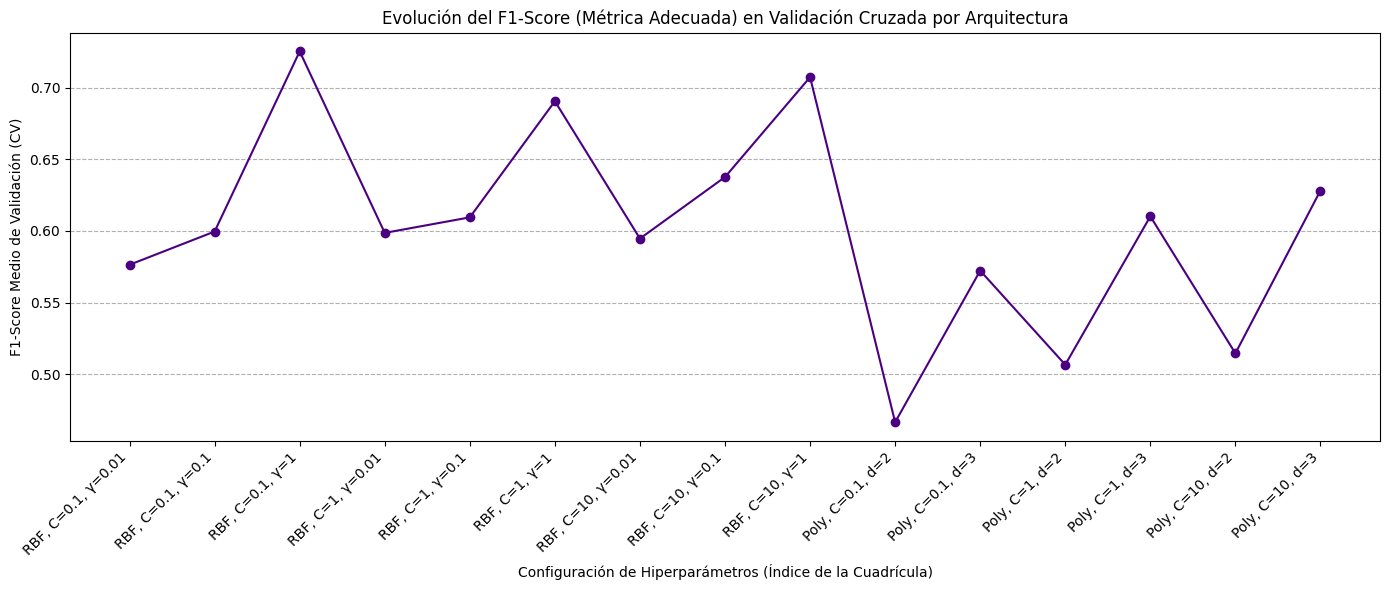


Arquitectura Elegida: La combinación de kernel e hiperparámetros con el mayor F1-Score medio en CV.


In [19]:
# --- 6. Resultados y Elección del Mejor Modelo ---
df_res = pd.DataFrame(grid_search_balanced.cv_results_)

# Filtramos las métricas de interés para visualización
df_metrics = df_res[[
    'params', 
    'mean_test_f1_pos', 
    'mean_test_auc', 
    'mean_test_accuracy', 
    'mean_test_precision_pos', 
    'mean_test_recall_pos'
]]

best_index = grid_search_balanced.best_index_
best_result = df_metrics.iloc[best_index]

best_params = grid_search_balanced.best_params_
best_kernel = best_params['svc__kernel']

print("\n=========================================================")
print("            🏆 Resultados de la Búsqueda de Kernel         ")
print("=========================================================")
print("MEJOR KERNEL Y PARÁMETROS:", best_params)
print(f"MÉTRICA DE SELECCIÓN (F1-Score) en CV: {best_result['mean_test_f1_pos']:.4f}")
print("---------------------------------------------------------")

# --- 7. Gráfica de la evolución de la métrica de mérito principal ---
# La representación de la evolución se hace a través de las diferentes combinaciones probadas
plt.figure(figsize=(14, 6))
# 'mean_test_f1_pos' es el F1-Score medio en el conjunto de validación (CV)
plt.plot(df_res.index, df_res['mean_test_f1_pos'], marker='o', linestyle='-', color='indigo')
plt.title(f"Evolución del F1-Score (Métrica Adecuada) en Validación Cruzada por Arquitectura")
plt.xlabel("Configuración de Hiperparámetros (Índice de la Cuadrícula)")
plt.ylabel("F1-Score Medio de Validación (CV)")

# Configuramos las etiquetas del eje X con el kernel y el parámetro C
labels = []
for p in df_res['params']:
    if p['svc__kernel'] == 'rbf':
        labels.append(f"RBF, C={p['svc__C']}, γ={p['svc__gamma']}")
    elif p['svc__kernel'] == 'poly':
        labels.append(f"Poly, C={p['svc__C']}, d={p['svc__degree']}")
    else:
        labels.append(str(p))

plt.xticks(df_res.index, labels, rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

print("\nArquitectura Elegida: La combinación de kernel e hiperparámetros con el mayor F1-Score medio en CV.")

In [20]:
# --- 8. Evaluación Final en el Conjunto de PRUEBA (Test) ---
mejor_modelo_svm = grid_search_balanced.best_estimator_

# Predicciones
y_prob_multi = mejor_modelo_svm.predict_proba(X_test)[:, 1]
y_pred_multi = mejor_modelo_svm.predict(X_test)

# Métricas finales
final_metrics = {
    "accuracy": accuracy_score(y_test, y_pred_multi),
    "precision_pos": precision_score(y_test, y_pred_multi),
    "recall_pos": recall_score(y_test, y_pred_multi),
    "f1_pos": f1_score(y_test, y_pred_multi),
    "auc": roc_auc_score(y_test, y_prob_multi)
}

print("\n=========================================================")
print(f"       ✅ Evaluación FINAL del Mejor Modelo ({best_kernel.upper()})        ")
print("=========================================================")
print("MÉTRICAS EN TEST:", final_metrics)
print("\nReporte de Clasificación en Test:")
print(classification_report(y_test, y_pred_multi))

# Aquí iría tu función para guardar resultados
# registrar_metricas("6. SVM No Lineal", y_test, y_pred_multi, y_prob_multi)


       ✅ Evaluación FINAL del Mejor Modelo (RBF)        
MÉTRICAS EN TEST: {'accuracy': 0.6466666666666666, 'precision_pos': 0.6758650897941305, 'recall_pos': 0.7836465210766886, 'f1_pos': 0.7257761053621825, 'auc': 0.7449547627596644}

Reporte de Clasificación en Test:
              precision    recall  f1-score   support

           0       0.58      0.44      0.50      1331
           1       0.68      0.78      0.73      1969

    accuracy                           0.65      3300
   macro avg       0.63      0.61      0.61      3300
weighted avg       0.64      0.65      0.64      3300



El modelo está completamente sesgado hacia los paquetes que llegan tarde

Wrapper con SVM

In [21]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report, make_scorer
)
from IPython.display import display

# ==============================================================================
# 1. PREPARACIÓN DE DATOS Y MÉTRICAS
# ==============================================================================
# Asumimos que X_train, X_test, y_train, y_test están cargados y listos.
# X_train = X_diseno_encoded.values
# X_test = X_test_encoded.values
# y_train = y_diseno.values
# y_test = y_test.values

# Define las 5 métricas (scorers)
f1_scorer = make_scorer(f1_score) 
auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'f1_pos': f1_scorer,
    'precision_pos': make_scorer(precision_score),
    'recall_pos': make_scorer(recall_score),
    'auc': auc_scorer
}

# Recuperamos los mejores parámetros del GridSearch BALANCEADO (Sección II)
# *** ASEGÚRATE DE QUE grid_search_balanced ESTÉ DEFINIDO CON EL MEJOR MODELO RBF ***
try:
    best_params = grid_search_balanced.best_params_
except NameError:
    print("ADVERTENCIA: Usando parámetros por defecto. ¡Asegúrate de ejecutar la Sección II (balanceada)!")
    # Parámetros de ejemplo si grid_search_balanced no está definido
    best_params = {'svc__kernel': 'rbf', 'svc__C': 1, 'svc__gamma': 0.1} 

# ==============================================================================
# 2. SELECCIÓN DE CARACTERÍSTICAS (RFE con LinearSVC)
# ==============================================================================

# Estimador base que SÍ tiene coef_ para RFE (SVM Lineal)
# Usamos un Pipeline para manejar el escalado dentro del RFE si fuera necesario
rfe_base_estimator = Pipeline([
    ('scaler', StandardScaler()), # Incluimos StandardScaler por si RFE lo requiere internamente
    ('lsvc', LinearSVC(
        penalty='l2', 
        dual=False, # Más rápido para n_samples > n_features
        C=best_params.get('svc__C', 1), # Usamos el C óptimo o 1 si no está
        class_weight='balanced',
        random_state=0,
        max_iter=5000 
    ))
])

# Inicializamos RFE (Lo envolvemos en un GridSearchCV para encontrar n_features_to_select óptimo)
# Probamos desde 1 característica hasta el número total de características
n_features_total = X_train.shape[1]
feature_range = list(range(1, n_features_total + 1))

rfe_grid_search = GridSearchCV(
    estimator=RFE(rfe_base_estimator, step=1),
    param_grid={'n_features_to_select': feature_range},
    scoring=f1_scorer, # Optimizamos el número de características basado en F1-Score
    cv=5,
    verbose=0,
    n_jobs=-1
)

print(f"Iniciando búsqueda para el número óptimo de características (probando 1 a {n_features_total})...")
rfe_grid_search.fit(X_train, y_train)

# 3. Aplicar la Selección Óptima
best_n_features = rfe_grid_search.best_params_['n_features_to_select']
print(f"Número Óptimo de Características (basado en F1-Score): {best_n_features}")

# Creamos el selector final RFE con el número óptimo encontrado
rfe_selector_final = RFE(
    estimator=rfe_base_estimator,
    n_features_to_select=best_n_features,
    step=1
)
rfe_selector_final.fit(X_train, y_train)

# Aplicar la Selección a los Conjuntos de Datos
selected_indices = np.where(rfe_selector_final.support_)[0]
X_train_rfe = X_train[:, selected_indices]
X_test_rfe = X_test[:, selected_indices]

print(f"Características seleccionadas (índices): {selected_indices}")
print(f"Dimensiones de los datos de entrenamiento con RFE: {X_train_rfe.shape}")

# ==============================================================================
# 4. RE-ENTRENAMIENTO Y EVALUACIÓN FINAL con SUB-CONJUNTO
# ==============================================================================

print("\nRe-entrenando el modelo SVM RBF óptimo con el subconjunto de características...")

# Re-inicializamos el modelo RBF óptimo (sin el escalador, ya que X_train_rfe ya estaba escalado)
final_svm_rfe = SVC(
    kernel=best_params['svc__kernel'],
    C=best_params['svc__C'],
    gamma=best_params.get('svc__gamma', 'scale'),
    probability=True,
    class_weight='balanced', # Mantenemos el peso de clase CRÍTICO
    random_state=0
)

final_svm_rfe.fit(X_train_rfe, y_train)

# Evaluación Final en Test
y_prob_rfe = final_svm_rfe.predict_proba(X_test_rfe)[:, 1]
y_pred_rfe = final_svm_rfe.predict(X_test_rfe)

# Métricas finales
final_metrics_rfe = {
    "accuracy": accuracy_score(y_test, y_pred_rfe),
    "precision_pos": precision_score(y_test, y_pred_rfe),
    "recall_pos": recall_score(y_test, y_pred_rfe),
    "f1_pos": f1_score(y_test, y_pred_rfe),
    "auc": roc_auc_score(y_test, y_prob_rfe)
}

print("\n=========================================================")
print(f"       ✅ Evaluación FINAL con Selección de Características (RFE)        ")
print("=========================================================")
print(f"Arquitectura: SVM {best_params['svc__kernel'].upper()} (Optimizada)")
print(f"Número de Características Usadas: {best_n_features}")
print("\nMETRICAS EN TEST (RFE):", final_metrics_rfe)
print("\nReporte de Clasificación en Test (RFE):")
print(classification_report(y_test, y_pred_rfe))

Iniciando búsqueda para el número óptimo de características (probando 1 a 10)...
Número Óptimo de Características (basado en F1-Score): 10
Características seleccionadas (índices): [0 1 2 3 4 5 6 7 8 9]
Dimensiones de los datos de entrenamiento con RFE: (7699, 10)

Re-entrenando el modelo SVM RBF óptimo con el subconjunto de características...

       ✅ Evaluación FINAL con Selección de Características (RFE)        
Arquitectura: SVM RBF (Optimizada)
Número de Características Usadas: 10

METRICAS EN TEST (RFE): {'accuracy': 0.6466666666666666, 'precision_pos': 0.6758650897941305, 'recall_pos': 0.7836465210766886, 'f1_pos': 0.7257761053621825, 'auc': 0.7449547627596644}

Reporte de Clasificación en Test (RFE):
              precision    recall  f1-score   support

           0       0.58      0.44      0.50      1331
           1       0.68      0.78      0.73      1969

    accuracy                           0.65      3300
   macro avg       0.63      0.61      0.61      3300
weighted a

Como vemos, los resultados son idénticos al SVM realizado antes. Esto indica que tan solo 10 carácteristicas del total eran relevantes para el modelo, siendo entonces ruido o irrelevantes las otras

## Sección III. Comparación de resultados

A continuación, vamos a comparar todos los modelos generados en las secciones anteriores con el objetivo de contrastar las aproximaciones lineales (SVM con kernel lineal y Regresión Logístico) frente a las no lineales (SVM con kernel no lineal), analizando las distintas figuras de mérito.

In [22]:
# Mostramos el diccionario donde hemos ido guardando los resultados
df_comparacion = pd.DataFrame(resultados_comparativa).T
columnas_ordenadas = ['Accuracy', 'F1-Score', 'Precision', 'Recall', 'AUC'] 
df_comparacion = df_comparacion[columnas_ordenadas].round(4)

display(df_comparacion.sort_values(by="AUC", ascending=False))

,Accuracy,F1-Score,Precision,Recall,AUC
RL (L2 - Tarea 1),0.6294,0.7226,0.6529,0.8090,0.7306
SVM Lineal,0.6706,0.7042,0.7585,0.6572,0.7261
SVM Lineal (Sin Norm),0.5545,0.6764,0.5970,0.7801,0.3545
